<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/UAPH4582/PH482_582/blob/main/08-Hackathon-NMR/Hackathon_NMR_Challenge.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
</table>


# Hackathon - NMR Challenge


### Problem Statement

- Nuclear Magnetic Resonance (NMR) is an experimental technique that allows for the control and measurement of nuclear spins in crystals and molecules.
- A common "recipe" for NMR is called the spin echo: the spins start aligned, begin to disperse, and are then refocused. This creates a sharp peak, or "echo", in the net magnetization $M$ of the material at a later time. When the spins interact with each other, this refocused echo can become highly distorted.
- Materials with strong electron-electron couplings have a variety of applications, from superconductivity to ferromagnetism. They also tend to enhance the nuclear spin-spin couplings, allowing NMR to act as a probe of these important systems.
- Design and train a model that predicts the strength and shape of interactions between the nuclear spins from simulated time-dependent magnetization curves, $M(t)$.

Before getting to any code, we first review the structure of this machine learning problem and introduce some of the details of the underlying physics we are trying to capture.




## Quick description of the ML problem

### Goal:
Predict three real numbers from an input vector of complex numbers.




## Introduction to NMR and spin echos

Although the NMR "spin echo" technique may sound complicated, the following animation created by Gavin W Morley (by way of https://en.wikipedia.org/wiki/Spin_echo) makes it much clearer!


![NMR Spin Echo Animation](HahnEcho_GWM.gif)


The red arrows in this animation represents the values of nuclear spins in the material.
They all begin in the same direction (up), and then an applied magnetic field rotates them into the x-y plane (indicated by the 90$^\circ$ pulse).
A constant external magnetic field in the z-direction did not affect the spins when they were pointing "up", but now that they lie in the x-y plane they begin to precess.


Because each nuclear spin sits in a slightly different magnetic environment, each one has a slightly different response to the background z-direction magnetic field, causing some to precess in a clockwise direction and others in a counterclockwise direction.


After a fixed amount of time, $t$ in the above animation, a second magnetic pulse is applied and rotates each spin 180$^\circ$ in the x-y plane.
After this, the spins continue to move as they did before, but because of the 180$^\circ$ pulse they are now effectively precessing  "backwards" compared to the original motion!
So after an additional time $t$ passes, the variations in precession time is canceled out, causing a refocusing of the spins.

This shows up as a measurable "echo" in the average spin magnetization of the material, and can be measured in experiments.
This is an important technique because the average spin magnetization is hard to measure during an applied "pulse", but there is no external pulse during the "echo", allowing for accurate measurement of the peak value and decay shape.

Here is a typical curve for the time-dependent magnetization $M(t)$ for a spin-echo in most materials:

![standard_spinecho.png](standard_spinecho.png)

Sometimes, a more complicated curve can occur, such as:

![coupled_echo.png](coupled_echo.png)

This more complicated structure has been caused by spin-spin interactions between the precessing nuclear spins. Normally, each spin precesses in a uniform way irrespective of the rest of the nuclei in the material. In this coupled case, however, the nuclear magnetization that occurs near the "echo" influences the spins' motions, modifying the shape of the observed echo.

## Electronic and nuclear spins

Most materials can be classified by their electronic properties into three categories: metal, insulator, and semiconductor.
These terms are based on a semi-classical description of the electrons in a crystal.
The electrons are treated as a collection of classical particles, with energies that depend on their momentum in a way determined by the atomic structure of the crystal.

However, there are other electronic phases of matter that are truly "quantum" and cannot be described accurately with a classical analogy.
In these scenarios, complicated structures in the electron states can give rise to large electronic spin density or strong electron-electron coupling.
Because of these strong couplings between electrons, they are often hard to probe experimentally.

Luckily, electrons can interact with the nuclar spins of a material (by way of the hyperfine-interaction).
If the electron-nuclear coupling becomes strong enough, then a non-neglible two-step process can couple the nuclei with each other throughout the material.
That two-step process is when a nuclear spin couples to an electron and changes its motion, and then that electron later "scatters" off another nuclear spin elsewhere in the material.

We represent this two-step scattering prcoess by way of an effective spin-spin coupling between a nuclei at position $r_j$ and $r_i$. **There are two datasets, "gauss" and "RKKY", and thus you will have to generate TWO models and hand in two models.**


The first is a simple gaussian function ("gauss"):

$T_1(i,j) = \alpha \exp{\left[ \left(\frac{-|r_j - r_i|}{\xi} \right)^{2} \right]}$

And the second is the traditional Ruderman–Kittel–Kasuya–Yosida function ("RKKY"):

$T_2(i,j) = \alpha x^{-4} \left( x \cos{x} - \sin{x} \right)$

with $x = 2 \frac{|r_j - r_i|}{\xi}$


For both function, $\alpha$ is the coupling strength and $\xi$ is the coupling length
Generally, $\alpha$ and $\xi$ will depend on the details of the nuclear-electron coupling and the quantum state of the electrons, but here we will sample them randomly to see if the spin-echo experiment can provide enough information to accurately "reverse engineer" these values from a single $M(t)$ curve.

Our simulations also include dissipation of the nuclear spins: due to couplings with the environment the spin information can be "lost".
This occurs at a time scale $T_\textrm{decay} \simeq \Gamma^{-1/2}$, with $\Gamma$ given by:

$\Gamma = 10^{-d}$

Our goal is to develop two models, one for each function, that accurately determine the above variables ($\alpha$, $\xi$, and $d$) from a single $M(t)$ curve. Note that RKKY is a harder problem.

## Load and view the simulated data

Three datafiles will be used for the training of both models. Each file has 6000 lines, representing 6000 simulated $M(t)$ curves for different choices of the three material parameters:

- \<model name\>_echos_model_r.txt  : Real part of the time-dependent magnetization, $\textrm{Re}(M(t))$.
- \<model name\>_echos_model_i.txt  : Imaginary part of the time-dependent magnetization, $\textrm{Im}(M(t))$.
- \<model name\>_mat_info_model.txt : The three material parameters ($\alpha$,$\xi$,$d$) introduced above.

Where \<model name\> is either "gauss" or "RKKY".

We also load two other echo files, which give an additional 6000 $M(t)$ curves. These will be used to judge the quality of your final models:

- \<model name\>_echos_eval_r.txt
- \<model name\>_echos_eval_i.txt

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import requests

print("Downloading files off google drive...")

f_prefix = "gauss"

# data for model creation
mat_file = f_prefix+"_mat_info_model.txt"
M_file_r = f_prefix+"_echos_model_r.txt" # real part of echos
M_file_i = f_prefix+"_echos_model_i.txt" # imaginary part of echos

asdf = "https://drive.google.com/uc?export=download&id="

r = requests.get("https://drive.google.com/uc?export=download&id=1J8CcJVQRpzSwue1vuHV9uB0bngdDrKCY",allow_redirects=True)
open(mat_file, "wb").write(r.content)
r = requests.get("https://drive.google.com/uc?export=download&id=1lBWcwF--1rrB8KCyCd0-5ZnPIjRrWkHg",allow_redirects=True)
open(M_file_r, "wb").write(r.content)
r = requests.get("https://drive.google.com/uc?export=download&id=1O7KKL-SW3vHePoRNk8YfLzX82wf2Z5ul",allow_redirects=True)
open(M_file_i, "wb").write(r.content)

# data for submission of final model
M_file_r = f_prefix+"_echos_eval_r.txt" # real part of echos
M_file_i = f_prefix+"_echos_eval_i.txt" # imaginary part of echos

r = requests.get("https://drive.google.com/uc?export=download&id=1prIrtO7XJs3PBe1MZiWUxK3VUkrChVvz",allow_redirects=True)
open(M_file_r, "wb").write(r.content)
r = requests.get("https://drive.google.com/uc?export=download&id=1vbKcuxe6z8cRGQdTqj_Q2u5Oow0D9hbU",allow_redirects=True)
open(M_file_i, "wb").write(r.content)

# now repeat, but for RKKY type function

f_prefix = "RKKY"    

# data for model creation
mat_file = f_prefix+"_mat_info_model.txt"
M_file_r = f_prefix+"_echos_model_r.txt" # real part of echos
M_file_i = f_prefix+"_echos_model_i.txt" # imaginary part of echos
r = requests.get("https://docs.google.com/uc?export=download&id=1lS9AJ3sUFI4cfM5jQj618x4shoaJMXVo",allow_redirects=True)
open(mat_file, "wb").write(r.content)
r = requests.get("https://docs.google.com/uc?export=download&id=1J21bKy8FTjoaGzHVdLXlWAao2UiWO7ml",allow_redirects=True)
open(M_file_r, "wb").write(r.content)
r = requests.get("https://docs.google.com/uc?export=download&id=1nf3Y_FcJJEWXJbjwREAkgcnVz2tDA__I",allow_redirects=True)
open(M_file_i, "wb").write(r.content)

# data for submission of final model
M_file_r = f_prefix+"_echos_eval_r.txt" # real part of echos
M_file_i = f_prefix+"_echos_eval_i.txt" # imaginary part of echos

r = requests.get("https://docs.google.com/uc?export=download&id=1Q46o_RnYZFWEjMVVF5m1VBI9HCltspyY",allow_redirects=True)
open(M_file_r, "wb").write(r.content)
r = requests.get("https://docs.google.com/uc?export=download&id=1-z2ADFrBlEhXN5Z_LHiRLA4Nds_9uvQq",allow_redirects=True)
open(M_file_i, "wb").write(r.content)    
    
    
print("Done with file downloads")

Done with file downloads


### Change the following "f_prefix" variable to select a different model to load and train on


In [2]:
f_prefix = "gauss"; # Gaussian functional between nuclei
#f_prefix = "RKKY"; # RKKY functional between nuclei

### Now load the data and format it correctly

In [3]:
mat_file = f_prefix+"_mat_info_model.txt"
M_file_r = f_prefix+"_echos_model_r.txt" # real part of echos
M_file_i = f_prefix+"_echos_model_i.txt" # imaginary part of echos

print("Loading into numpy arrays...")
# settings of each simulated material:
# format:  |   α  |   ξ  |   d  |
mat_info = np.loadtxt(mat_file, comments="#", delimiter=None, unpack=False);

# M(t) curve for each simulation, model:
M_r = np.loadtxt(M_file_r, comments="#", delimiter=None, unpack=False);
M_i = np.loadtxt(M_file_i, comments="#", delimiter=None, unpack=False);
M = M_r + 1j*M_i;

# M(t) curve for each simulation, eval:
M_file_r = f_prefix+"_echos_eval_r.txt" # real part of echos
M_file_i = f_prefix+"_echos_eval_i.txt" # imaginary part of echos

M_r_eval = np.loadtxt(M_file_r, comments="#", delimiter=None, unpack=False);
M_i_eval = np.loadtxt(M_file_i, comments="#", delimiter=None, unpack=False);
M_eval = M_r_eval + 1j*M_i_eval;

print("Done with numpy loads")

Loading into numpy arrays...
Done with numpy loads


### View the data with three plots, two with a specific curve and one with a lot of curves

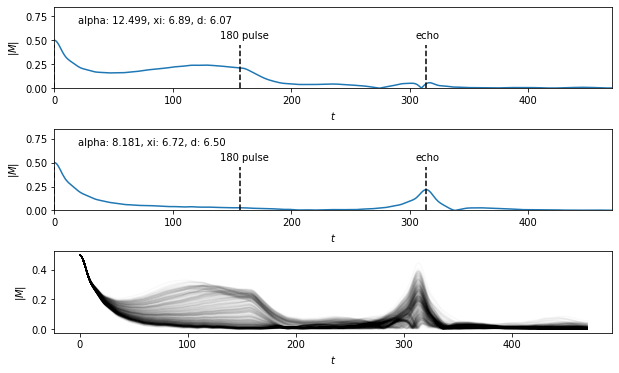

In [4]:
fig1, ax1 = plt.subplots(3,1, figsize=(10,6));

# change the following to see different curves
plot_idx1 = 0; # weak spin-spin coupling
plot_idx2 = 10; # strong spin-spin coupling

# string format for material parameter plotting
mat_format = "alpha: %.3f, xi: %.2f, d: %.2f";

# view the selected curve, with a label of the material data
ax1[0].plot(abs(M[plot_idx1,:]));
ax1[0].text(20,0.68, mat_format % tuple(mat_info[plot_idx1,:]) );
ax1[0].plot([0, 0],[0, .45],'--k')
ax1[0].plot([157, 157],[0, .45],'--k')
ax1[0].text(140,0.52,"180 pulse")
ax1[0].text(305,0.52,"echo")
ax1[0].plot([2*157, 2*157],[0, .45],'--k')
ax1[0].axis([0, 471, 0, 0.85])
ax1[0].set(ylabel="$|M|$", xlabel="$t$");

# view the selected curve, with a label of the material data
ax1[1].plot(abs(M[plot_idx2,:]));
ax1[1].text(20,0.68, mat_format % tuple(mat_info[plot_idx2,:]) );
ax1[1].plot([0, 0],[0, .45],'--k')
ax1[1].plot([157, 157],[0, .45],'--k')
ax1[1].text(140,0.52,"180 pulse")
ax1[1].text(305,0.52,"echo")
ax1[1].plot([2*157, 2*157],[0, .45],'--k')
ax1[1].axis([0, 471, 0, 0.85])
ax1[1].set(ylabel="$|M|$", xlabel="$t$");

ax1[2].plot(abs(M[1:500,:]).T,color=(0,0,0,.025));
ax1[2].set(ylabel="$|M|$", xlabel="$t$");

fig1.subplots_adjust(hspace=.5)

### Truncate, scale, and partition the training/testing sets

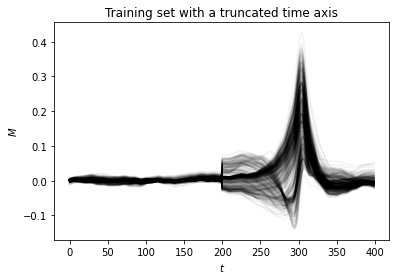

In [5]:
# number of M(t) curves
N_data = np.shape(M)[0]
# truncate time points
# !!! NOTE: May want to use all of the curve, takes longer to train though !!!
time_keep = range(210,410); # centered roughly at the echo
M_trunc = M[:,time_keep];
# split into real and imaginary
M_trunc_uncomplex = np.concatenate((np.real(M_trunc), np.imag(M_trunc)),axis=1)

# rescale data
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

mat_info_scaled = sc.fit_transform(mat_info);

# partition data into a training and testing set using a random partition
from sklearn.model_selection import train_test_split
M_train, M_test, mat_train, mat_test = train_test_split(M_trunc_uncomplex, mat_info_scaled, test_size=0.1)

# plot the fist 500 elements of the training set, for visualizing variations in the data
plt.plot((M_train[1:500,:]).T,color=(0,0,0,.05));
plt.xlabel("$t$")
plt.ylabel("$M$")
plt.title("Training set with a truncated time axis");

## Example solution: a simple neural net (NN)
- Our input nodes are the vector $[\textrm{Re}(M(t)), \textrm{Im}(M(t))]$, which is a few hundred elements.
- Our output nodes are the three material parameters.
- We will use a standard NN predict the material properties from $M(t)$.


In [7]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.optimizers import SGD # gradient descent optimizer

# first we build the model

N = np.shape(M_train[0])[0] # number of input values from M(t) curve

# define the net
nn = Sequential()
# Let's try N -> 100 -> 40 -> 3, e.g. 2 hidden layers
nn.add(Dense(100,input_dim=N, activation='relu'))
nn.add(Dense(40, activation='relu'))
nn.add(Dense(3, activation='linear'))

nn.compile(loss='mean_squared_error', optimizer=SGD(lr=0.01, momentum = 0.95) )

2022-04-12 16:38:41.047869: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/usr/local/anaconda3/envs/py10/lib/python3.10/site-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [8]:
# now train it
history = nn.fit(M_train, mat_train, epochs=200,batch_size=128, verbose=2)

Epoch 1/200
43/43 - 0s - loss: 0.9922 - 364ms/epoch - 8ms/step
Epoch 2/200
43/43 - 0s - loss: 0.9567 - 60ms/epoch - 1ms/step
Epoch 3/200
43/43 - 0s - loss: 0.9114 - 59ms/epoch - 1ms/step
Epoch 4/200
43/43 - 0s - loss: 0.8325 - 56ms/epoch - 1ms/step
Epoch 5/200
43/43 - 0s - loss: 0.7375 - 58ms/epoch - 1ms/step
Epoch 6/200
43/43 - 0s - loss: 0.6899 - 59ms/epoch - 1ms/step
Epoch 7/200
43/43 - 0s - loss: 0.6609 - 59ms/epoch - 1ms/step
Epoch 8/200
43/43 - 0s - loss: 0.6429 - 59ms/epoch - 1ms/step
Epoch 9/200
43/43 - 0s - loss: 0.6196 - 59ms/epoch - 1ms/step
Epoch 10/200
43/43 - 0s - loss: 0.5988 - 59ms/epoch - 1ms/step
Epoch 11/200
43/43 - 0s - loss: 0.5807 - 58ms/epoch - 1ms/step
Epoch 12/200
43/43 - 0s - loss: 0.5540 - 57ms/epoch - 1ms/step
Epoch 13/200
43/43 - 0s - loss: 0.5459 - 58ms/epoch - 1ms/step
Epoch 14/200
43/43 - 0s - loss: 0.5311 - 60ms/epoch - 1ms/step
Epoch 15/200
43/43 - 0s - loss: 0.5271 - 57ms/epoch - 1ms/step
Epoch 16/200
43/43 - 0s - loss: 0.5177 - 59ms/epoch - 1ms/step


19/19 [==============================] - 0s 992us/step - loss: 0.1138
test loss: 0.1138189435005188


Text(0.5, 1.0, 'Dissipation strength')

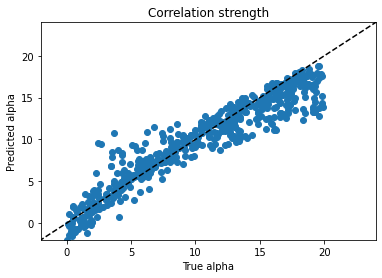

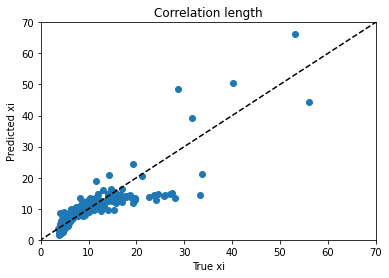

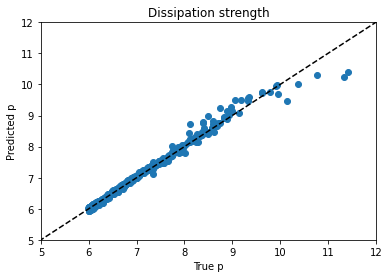

In [9]:
# check results on test set

results = nn.evaluate(M_test,mat_test, batch_size=32);
print("test loss:", results)
nn_test_sc = sc.inverse_transform(nn.predict(M_test));
mat_test_sc = sc.inverse_transform(mat_test);

plt.scatter(mat_test_sc[:,0],nn_test_sc[:,0]);
plt.plot([-100,100],[-100, 100],"--k")
plt.xlabel("True alpha");
plt.ylabel("Predicted alpha");
plt.axis([-2, 24, -2, 24])
plt.title("Correlation strength")

plt.figure()
plt.scatter(mat_test_sc[:,1],nn_test_sc[:,1]);
plt.plot([-100, 100],[-100, 100],"--k")
plt.xlabel("True xi");
plt.ylabel("Predicted xi");
plt.axis([0, 70, 0, 70])
plt.title("Correlation length")

plt.figure()
plt.scatter(mat_test_sc[:,2],nn_test_sc[:,2]);
plt.plot([-100, 100],[-100, 100],"--k")
plt.xlabel("True p");
plt.ylabel("Predicted p");
plt.axis([5, 12, 5, 12])
plt.title("Dissipation strength")




## Heatmap of important features in the time domain

It can be helpful to visualize the relative "importance" of each input element by back-propagating gradients of the output. For example, at a given t, we are computing for $\alpha$:

$G_\alpha(t) = \sum_{i}  \frac{d \alpha}{d M_i(t)} $

and displaying it in red in the first plot below.

Does the real part of the data (first half of the x-axis) seem important?

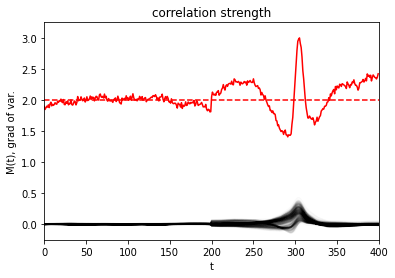

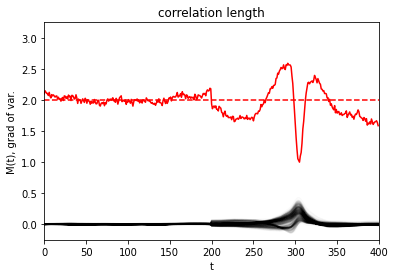

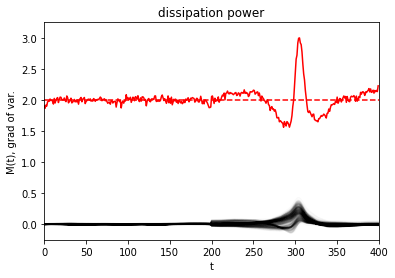

In [10]:
# heatmap of feature importance in the time domain
from keras import backend as k
import tensorflow as tf

var_names = ["correlation strength", "correlation length", "dissipation power"]

for tar_var in range(3):
    in_tensor = tf.convert_to_tensor(M_test) # we will track gradients w.r.t. M(t)
    with tf.GradientTape() as t:
        t.watch(in_tensor)
        tar_output = tf.gather(nn(in_tensor), tar_var, axis=1) # keep track of the tar_var output

    grads = t.gradient(tar_output, in_tensor).numpy() # comput gradient using tensorflow
    grad_sum = np.sum((grads),axis=0) # sum along all testing curves

    plt.figure()
    plt.plot((M_train[1:500,:]).T,color=(0,0,0,.025))
    plt.plot(2+grad_sum/np.max(np.abs(grad_sum)),'r')
    plt.plot([0, 400],[2, 2],'--r')
    plt.title(var_names[tar_var])
    plt.xlabel('t')
    plt.axis([0, 400, -.25, 3.25])
    plt.ylabel('M(t), grad of var.')


## Submission format

__We ask you to submit two models__.

When we downloaded the data for the model development, we also downloaded spin echos for evaluation of our models, like "gauss_echos_eval_r.txt" and "RKKY_echos_eval_i.txt".
These share the same format as the "\<model_type\>\_echos_model_*.txt," used for the model training above.

Use your model to predict the three spin-interaction variables from the echos, and submit your results for **each model** in a tab delimited .txt file of dimensions 6000 x 3 matching the "\<model_type\>\_mat_info_model.txt" format.

That is, the columns should be:

| $\alpha$ | $\xi$ | $d$ |
      
and there should be 6000 rows.

Name this file "\<model_type\>_mat_info_eval.txt"

The quality of the model will be judged by the minimization of normalized mean-square error:


$\textrm{Err} = \sum_{v=1}^{3} \sum_{i=i}^{6000} \left( \tilde{v}^i_\textrm{model} - \tilde{v}^i_\textrm{true} \right)^2 $

where $v^i$ is one of the three spin-interaction variables for echo number $i$, and the tilde represents normalization of each variable (using the StandardScalar() object used above).


Your submission should include:
- Your ipython notebook (`.ipynb`),
- A PDF copy of your notebook together with a description of what you have done,
- Your model's evaluation of the Gaussian data ("gauss_mat_info_eval.txt"),
- Your model's evaluation of the RKKY data ("RKKY_mat_info_eval.txt").
